In [106]:
from utils import database

import numpy as np
import pandas as pd

import folium as fl
from folium import plugins
import geopandas as gpd

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("classic")

In [107]:
properties = database.get_properties()

df = pd.DataFrame(
    properties, 
    columns=['price', 'latitude', 'longitude']
)

df['payment_interval'] = df['price'].str.split(" ").str.get(-1)
df['price'] = df['price'].str.split("£").str.get(1).str.split(" ").str.get(0).str.replace(",","").astype(np.float32)
df[['latitude','longitude']] = df[['latitude', 'longitude']].astype(np.float)

def convert_price(x):
    
    if x['payment_interval'] == 'pw':
        return x['price'] * 4
    else:
        return x['price']

df['monthly_price'] = df.apply(convert_price, axis=1)

df.head()

price  latitude  longitude payment_interval  monthly_price
0  1700.0  51.55734    0.09773              pcm         1700.0
1   390.0  51.51157   -0.06924               pw         1560.0
2  1700.0  51.46251   -0.17827              pcm         1700.0
3  1300.0  51.53826    0.07640              pcm         1300.0
4   495.0  51.54307   -0.29056              pcm          495.0

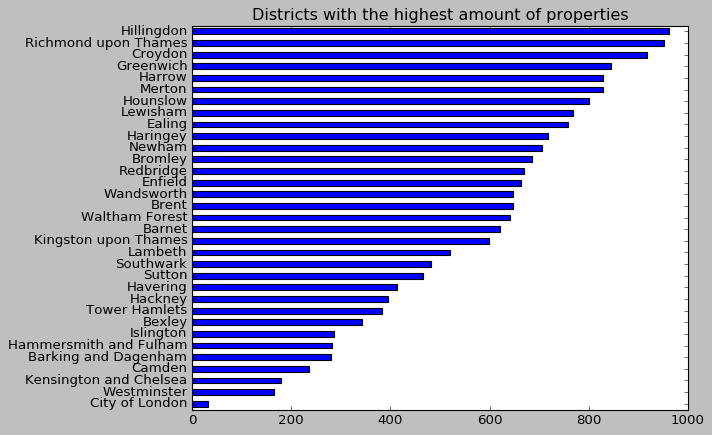

In [99]:
df = df[df['payment_interval'] == 'pcm']


london_districts = gpd.read_file("london.geojson")
london_districts['centroid_x'] = london_districts.geometry.centroid.x
london_districts['centroid_y'] = london_districts.geometry.centroid.y

properties_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=london_districts.crs)

df = gpd.sjoin(london_districts, properties_geo)

df['name'].value_counts().sort_values().plot(kind='barh')

plt.title("Districts with the highest amount of properties")
plt.show()

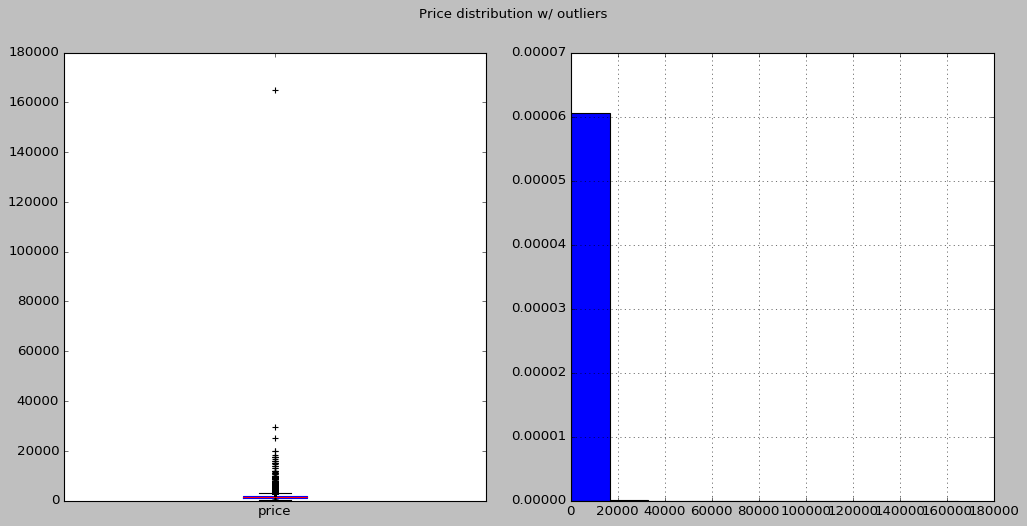

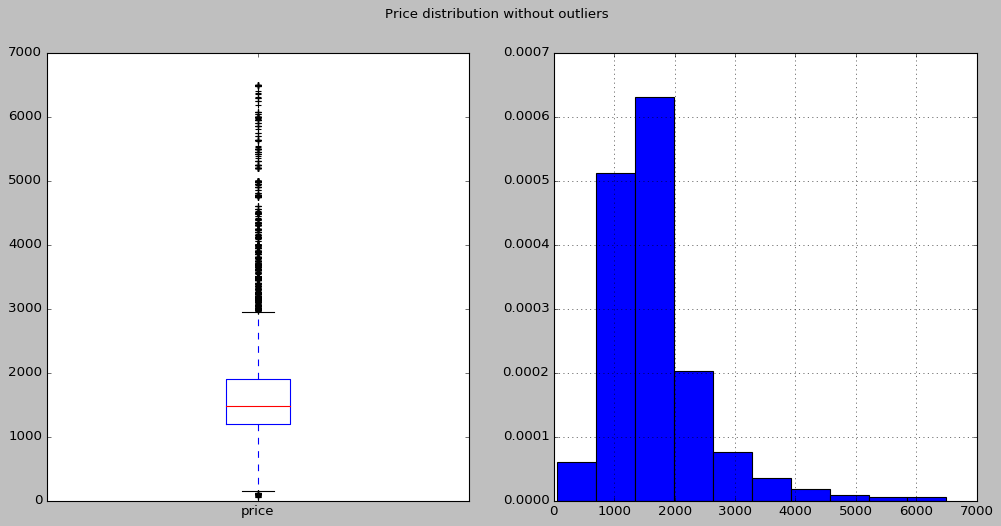

18595

In [100]:
fig, axis = plt.subplots(1,2, figsize=(15,7))


df['price'].plot(kind='box', ax=axis[0], title="")
df['price'].hist(ax=axis[1], density=1)

fig.suptitle("Price distribution w/ outliers")
plt.show()

# removing outliers
df = df[np.abs(df['price'] - df['price'].mean() ) <= df['price'].std() * 3]

fig, axis = plt.subplots(1,2, figsize=(15,7))


df['price'].plot(kind='box', ax=axis[0], title="")
df['price'].hist(ax=axis[1], density=1)

fig.suptitle("Price distribution without outliers")
plt.show()

len(df)

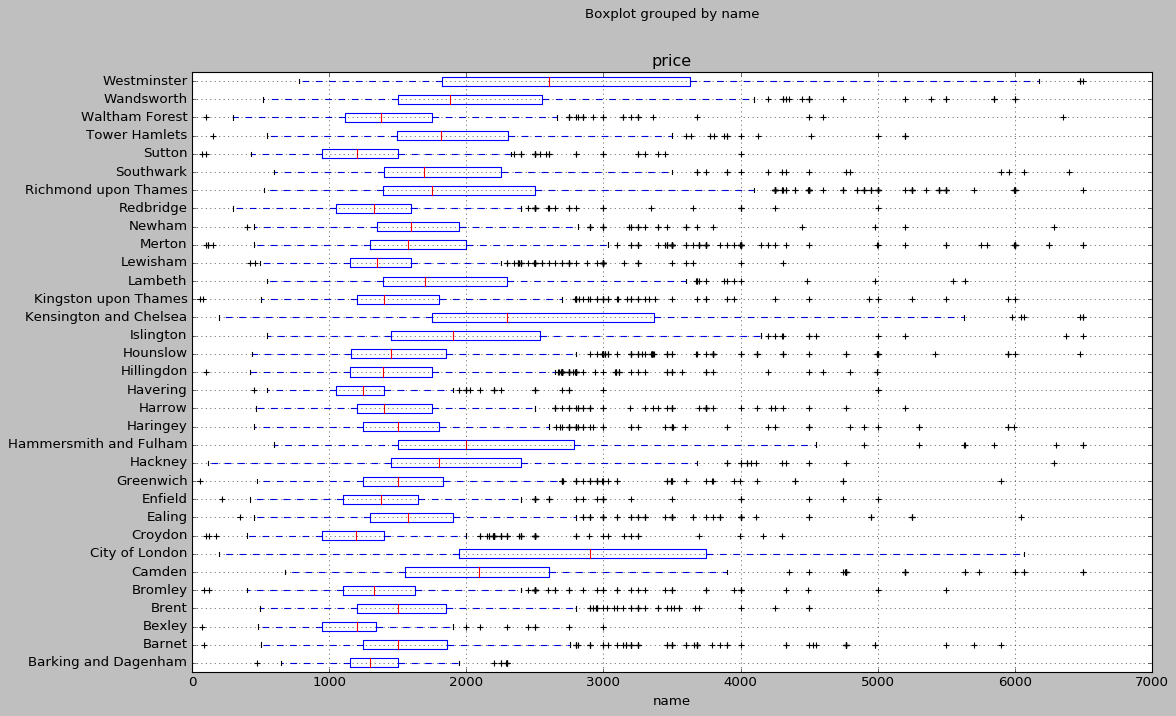

/home/marco/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [105]:
district_average_price = df.groupby('name', as_index=False)['price'].mean()

# Add the district coordinates
avg_price_df = london_districts.merge(district_average_price, on="name")

df.sort_values(by='price').boxplot(column='price', by='name', vert=False, figsize=(15,10))
plt.show()

m = fl.Map(
    location=[51.518055, -0.181273],
    zoom_start=10,
    zoom_control=False
)

fl.Choropleth(
    geo_data = avg_price_df,
    name="geometry",
    data=avg_price_df,
    columns=['name', 'price'],
    fill_color="YlOrRd",
    key_on="feature.properties.name",
    legend_name = 'Properties monthly rent price'
).add_to(m)

[
    fl.Marker(
        location=[row['centroid_y'], row['centroid_x']],
        popup=row['name'] 
    ).add_to(m)
    
    for ix, row in london_districts.iterrows()
]

display(m)